In [2]:
import cv2
import glob, os
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import heapq

In [3]:
folder = r"C:\Users\adibh\Downloads\archive (4)\Data\human"
image_paths = glob.glob(os.path.join(folder, "*.jpg"))
images = [cv2.resize(cv2.imread(p), (256, 256)) for p in image_paths]
print("Loaded", len(images), "images from dataset.")

Loaded 202 images from dataset.


In [5]:
QY = np.array([
    [16,11,10,16,24,40,51,61],
    [12,12,14,19,26,58,60,55],
    [14,13,16,24,40,57,69,56],
    [14,17,22,29,51,87,80,62],
    [18,22,37,56,68,109,103,77],
    [24,35,55,64,81,104,113,92],
    [49,64,78,87,103,121,120,101],
    [72,92,95,98,112,100,103,99]
])
QC = np.array([
    [17,18,24,47,99,99,99,99],
    [18,21,26,66,99,99,99,99],
    [24,26,56,99,99,99,99,99],
    [47,66,99,99,99,99,99,99],
    [99,99,99,99,99,99,99,99],
    [99,99,99,99,99,99,99,99],
    [99,99,99,99,99,99,99,99],
    [99,99,99,99,99,99,99,99]
])
def dct_compress_ycbcr(img, q_scale=1):
    ycbcr = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    Y, Cb, Cr = cv2.split(ycbcr)
    Cb = cv2.resize(Cb, (128, 128), interpolation=cv2.INTER_AREA)
    Cr = cv2.resize(Cr, (128, 128), interpolation=cv2.INTER_AREA)
    total_nonzero = 0
    total_coeff = 0
    def compress_channel(channel, Q):
        nonlocal total_nonzero, total_coeff
        h, w = channel.shape
        out = np.zeros((h, w), dtype=np.float32)
        for i in range(0, h, 8):
            for j in range(0, w, 8):
                block = channel[i:i+8, j:j+8].astype(float) - 128
                dct_block = cv2.dct(block)
                q_block = np.round(dct_block / (Q * q_scale))
                total_nonzero += np.count_nonzero(q_block)
                total_coeff += q_block.size
                dct_block_recon = q_block * (Q * q_scale)
                out[i:i+8, j:j+8] = cv2.idct(dct_block_recon) + 128
        return np.clip(out, 0, 255).astype(np.uint8)
    Yc = compress_channel(Y, QY)
    Cbc = compress_channel(Cb, QC)
    Crc = compress_channel(Cr, QC)
    Cbc = cv2.resize(Cbc, (256, 256), interpolation=cv2.INTER_LINEAR)
    Crc = cv2.resize(Crc, (256, 256), interpolation=cv2.INTER_LINEAR)
    compressed = cv2.merge([Yc, Crc, Cbc])
    compressed_bgr = cv2.cvtColor(compressed, cv2.COLOR_YCrCb2BGR)
    compression_ratio = total_coeff / total_nonzero if total_nonzero else 1
    compressed_size = int((img.size * 8) / compression_ratio)
    return compressed_bgr, compressed_size

In [6]:
class Node:
    def __init__(self, sym, freq):
        self.sym = sym
        self.freq = freq
        self.left = None
        self.right = None
    def __lt__(self, other):
        return self.freq < other.freq
def huffman_tree(freqs):
    heap = [Node(s, f) for s, f in freqs.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        l, r = heapq.heappop(heap), heapq.heappop(heap)
        new = Node(None, l.freq + r.freq)
        new.left, new.right = l, r
        heapq.heappush(heap, new)
    return heap[0]
def huffman_codes(node, prefix="", codebook={}):
    if node is None: return
    if node.sym is not None: codebook[node.sym] = prefix
    huffman_codes(node.left, prefix + "0", codebook)
    huffman_codes(node.right, prefix + "1", codebook)
    return codebook
def huffman_compress(img):
    flat = img.flatten().tolist()
    freqs = Counter(flat)
    tree = huffman_tree(freqs)
    codes = huffman_codes(tree)
    encoded = "".join([codes[v] for v in flat])
    return len(encoded)  

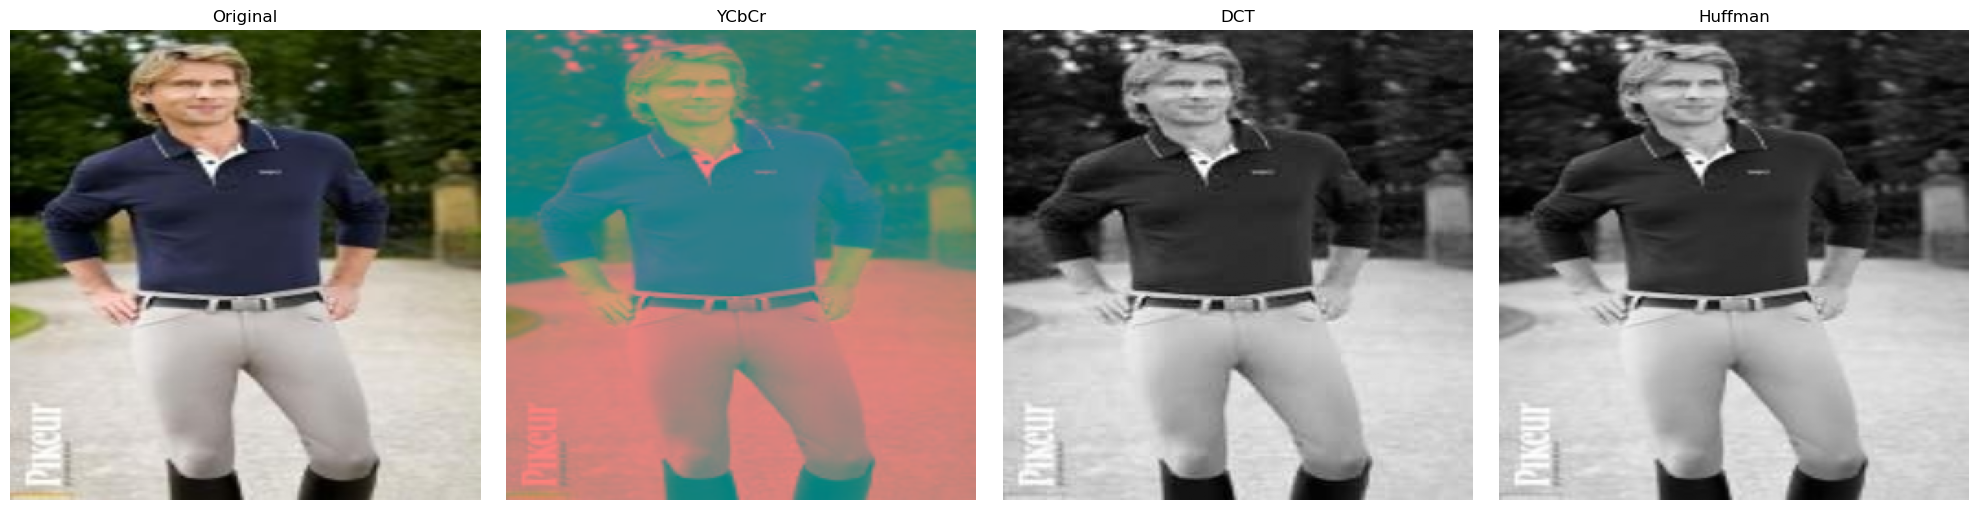

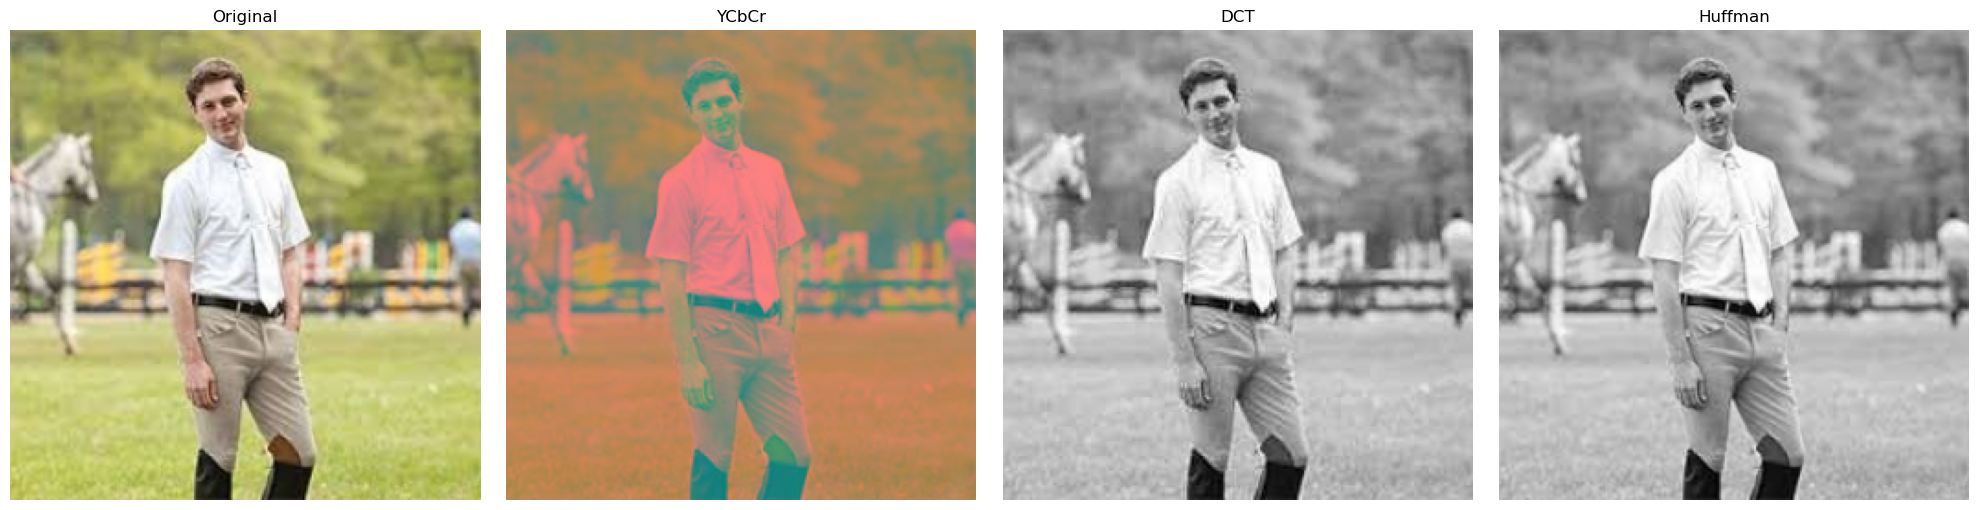

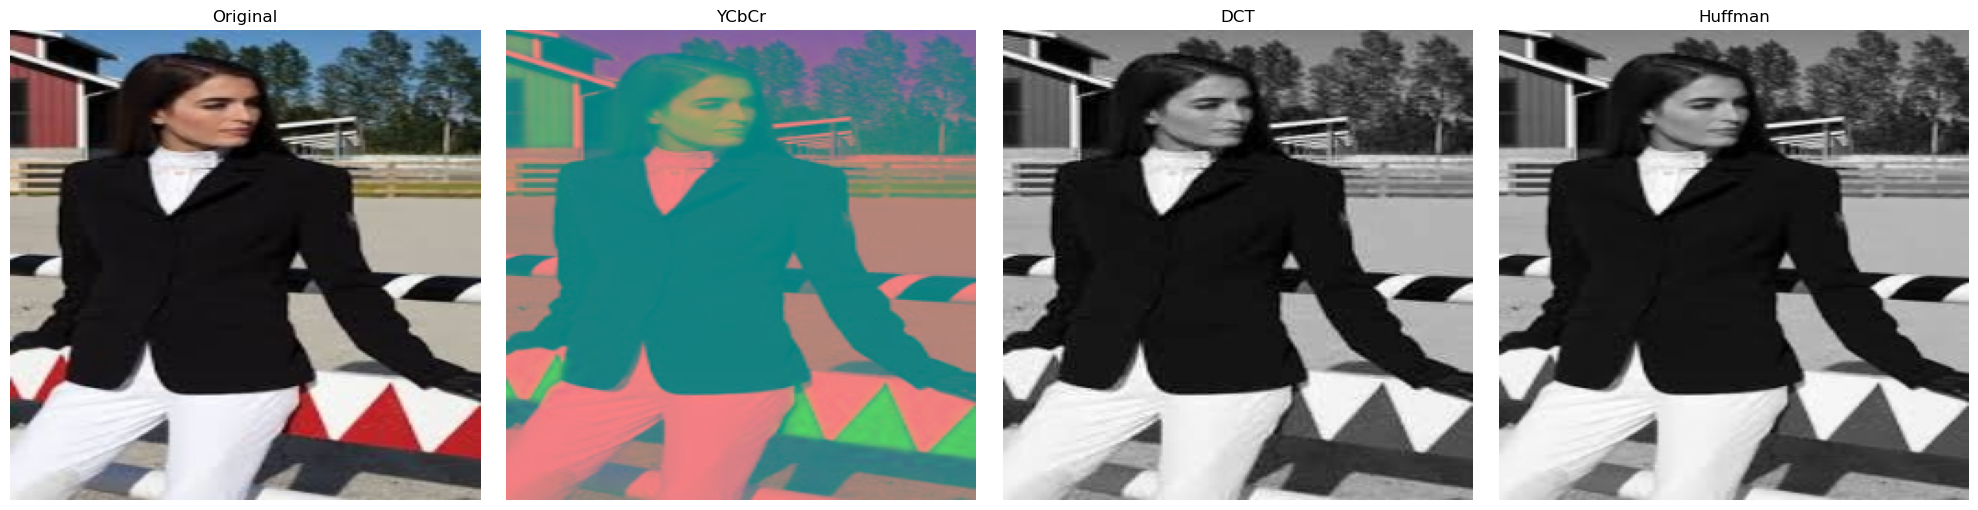

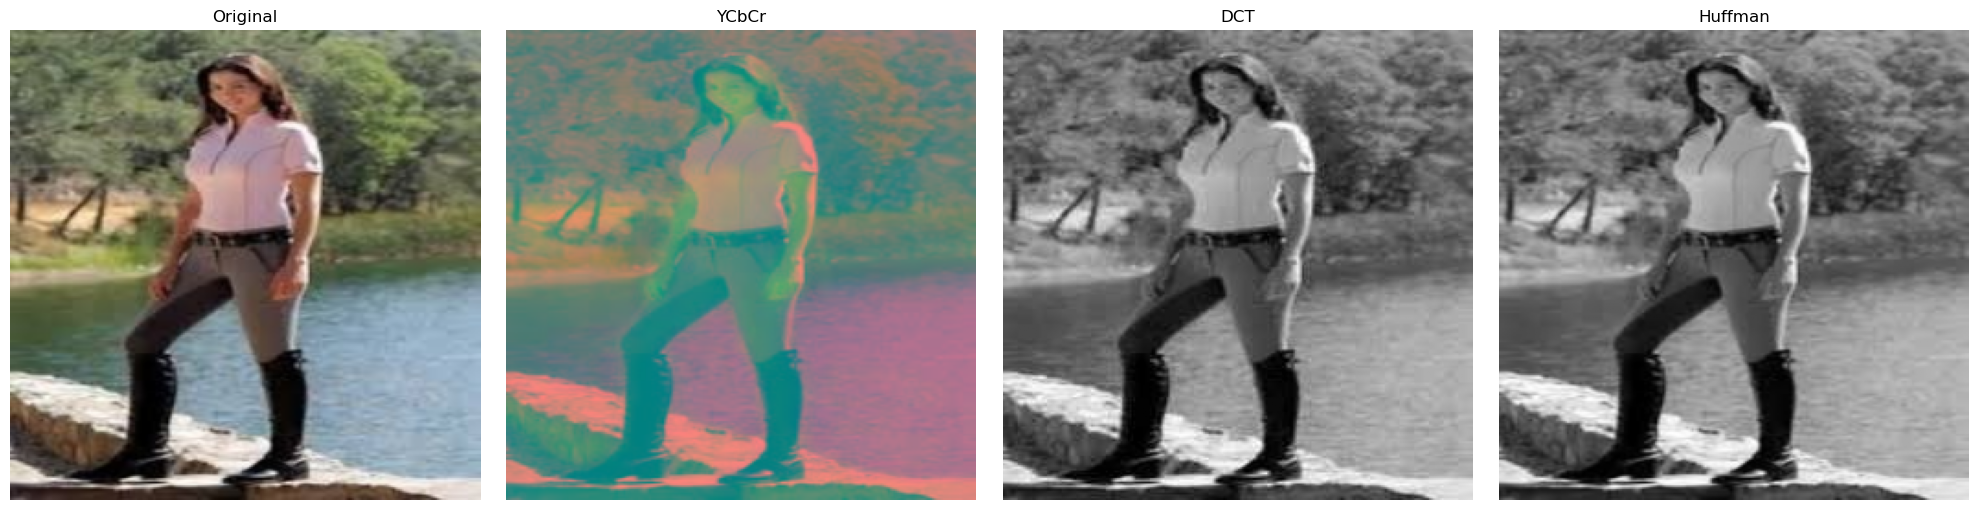

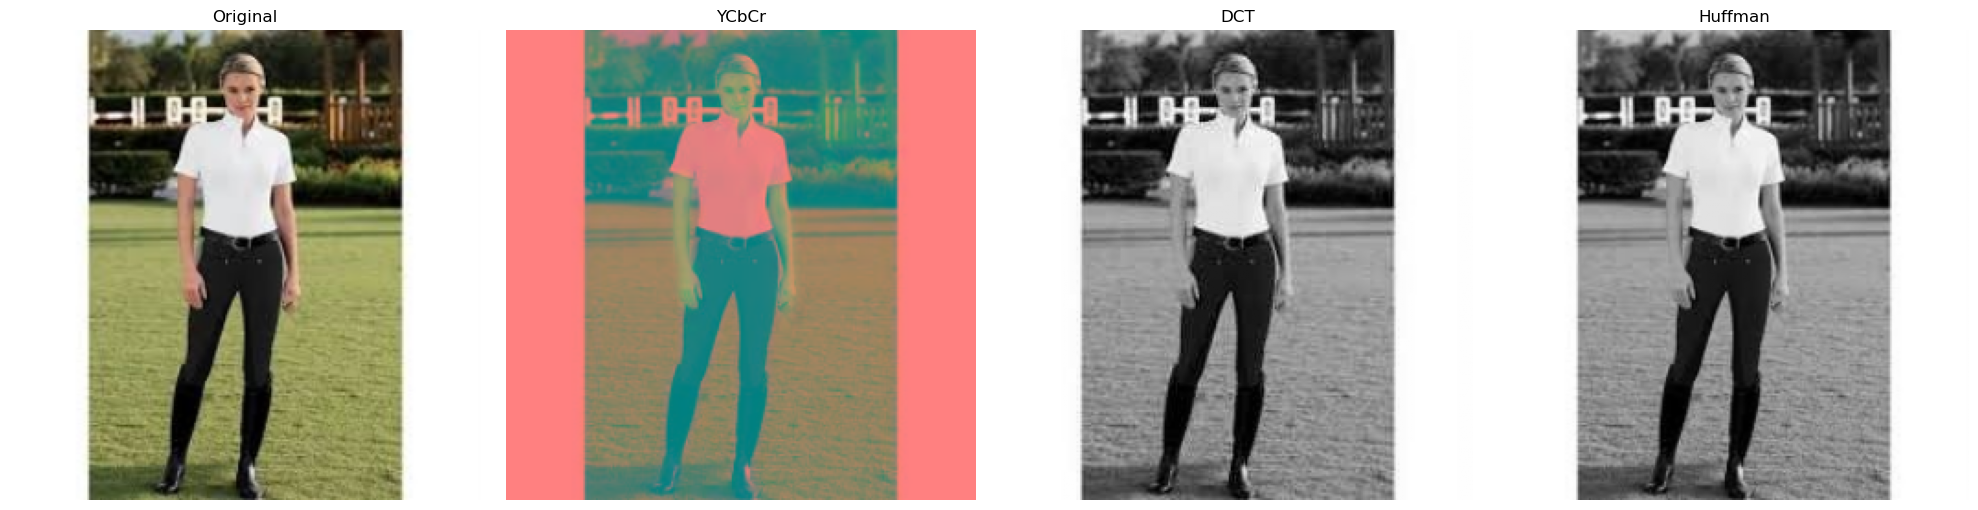

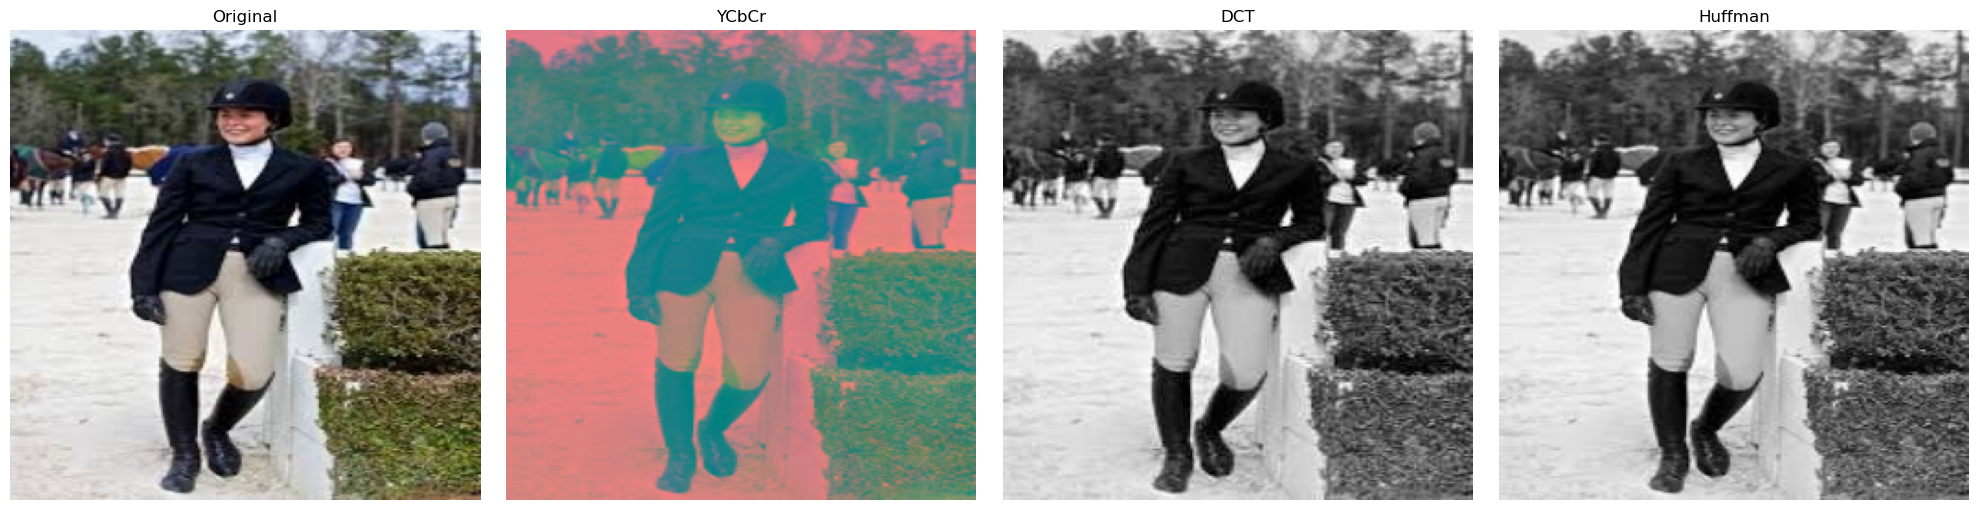

In [12]:
for idx, img in enumerate(images[:6]):
    original_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ycbcr = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    dct_compressed_bgr, dct_size_bits = dct_compress_ycbcr(img)
    dct_gray = cv2.cvtColor(dct_compressed_bgr, cv2.COLOR_BGR2GRAY)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    huffman_size_bits = huffman_compress(gray)
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(original_rgb)
    plt.title("Original")
    plt.axis("off")
    plt.subplot(1, 4, 2)
    plt.imshow(ycbcr)
    plt.title("YCbCr")
    plt.axis("off")
    plt.subplot(1, 4, 3)
    plt.imshow(dct_gray, cmap='gray')
    plt.title("DCT")
    plt.axis("off")
    plt.subplot(1, 4, 4)
    plt.imshow(gray, cmap='gray')
    plt.title("Huffman")
    plt.axis("off")
    plt.tight_layout()
    plt.show()